In [1]:
#Allocating GPU for the models resource

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 256
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
print("Class Names: ", class_names)

print("Length of Dataset:", len(dataset))

Class Names:  ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Length of Dataset: 269


In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(8, 256, 256, 3)
[0 0 0 1 0 0 0 1]


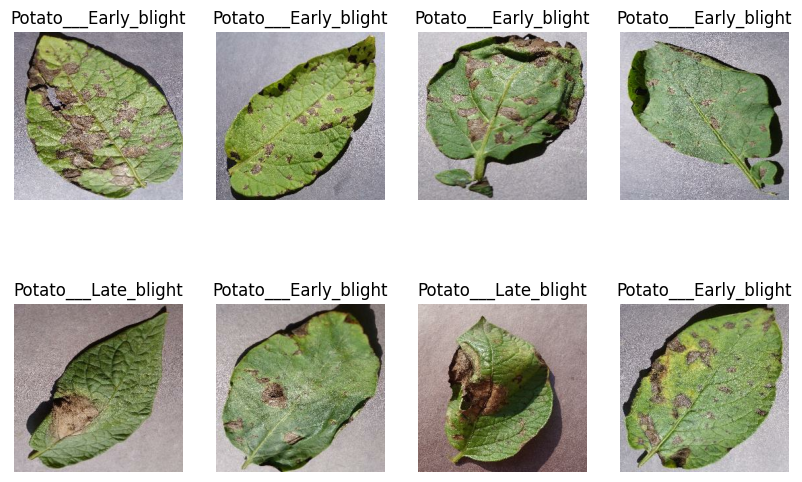

In [6]:
plt.figure(figsize=(10, 10))

for image_batch, label_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

plt.show()

In [7]:
train_size = 0.8
train_set_size = len(dataset) * train_size

print(train_set_size)

215.20000000000002


In [8]:
train_ds = dataset.take(215)
train_ds_length = len(train_ds)

print(train_ds_length)

215


In [9]:
test_ds = dataset.skip(215)
test_ds_length = len(test_ds)

print(test_ds_length)

54


In [10]:
val_size = 0.1
val_set_size = len(dataset) * val_size

print(val_set_size)

26.900000000000002


In [11]:
val_ds = test_ds.take(27)
val_ds_length = len(val_ds)

print(val_ds_length)

27


In [12]:
test_ds = test_ds.skip(27)
test_ds_length = len(test_ds)

print(test_ds_length)

27


In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)  # Corrected

    return train_ds, val_ds, test_ds

In [14]:
print("Training Dataset Size: ", len(train_ds))
print("Validation Dataset Size: ", len(val_ds))
print("Test Dataset Size: ", len(test_ds))

Training Dataset Size:  215
Validation Dataset Size:  27
Test Dataset Size:  27


In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.experimental.preprocessing.Rescaling(1.0/25)
])

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [19]:
from tensorflow.keras.applications import InceptionV3

IMAGE_SIZE = 256
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 50
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

base_model = InceptionV3(include_top = False, weights = 'imagenet', input_shape = input_shape)

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                      

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
215/215 [==============================] - 63s 187ms/step - loss: 0.5882 - accuracy: 0.7488 - val_loss: 0.5068 - val_accuracy: 0.8077
Epoch 2/50
215/215 [==============================] - 34s 157ms/step - loss: 0.4625 - accuracy: 0.8116 - val_loss: 0.3142 - val_accuracy: 0.8750
Epoch 3/50
215/215 [==============================] - 34s 157ms/step - loss: 0.4516 - accuracy: 0.8186 - val_loss: 0.3541 - val_accuracy: 0.8750
Epoch 4/50
215/215 [==============================] - 34s 158ms/step - loss: 0.4238 - accuracy: 0.8297 - val_loss: 0.4608 - val_accuracy: 0.8269
Epoch 5/50
215/215 [==============================] - 35s 161ms/step - loss: 0.4072 - accuracy: 0.8436 - val_loss: 0.4271 - val_accuracy: 0.8413
Epoch 6/50
215/215 [==============================] - 34s 156ms/step - loss: 0.3814 - accuracy: 0.8419 - val_loss: 0.4346 - val_accuracy: 0.8317
Epoch 7/50
215/215 [==============================] - 34s 156ms/step - loss: 0.3848 - accuracy: 0.8459 - val_loss: 0.3297 - val_ac

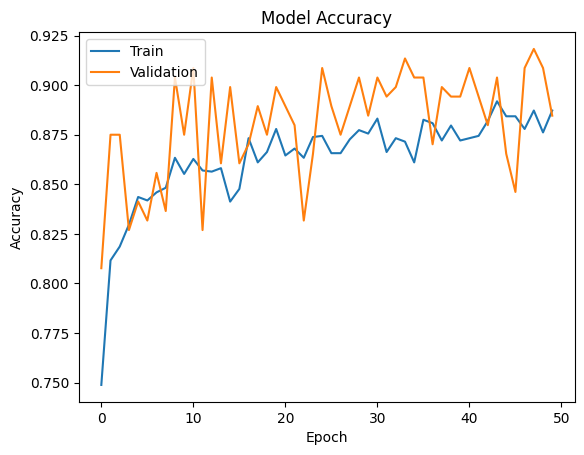

In [23]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
except NameError:
    print("Variable 'history' is not defined. Please make sure you have executed the cell that defines this variable.")

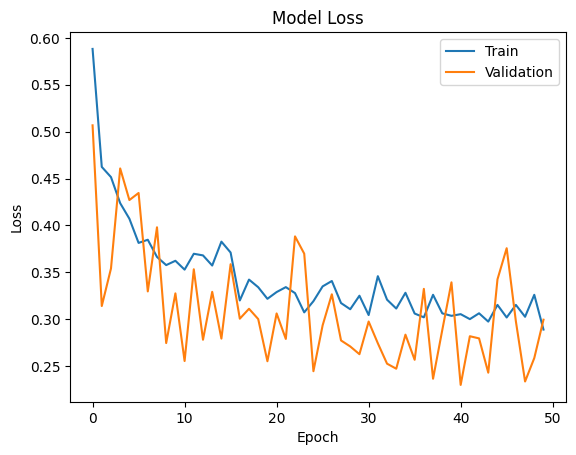

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

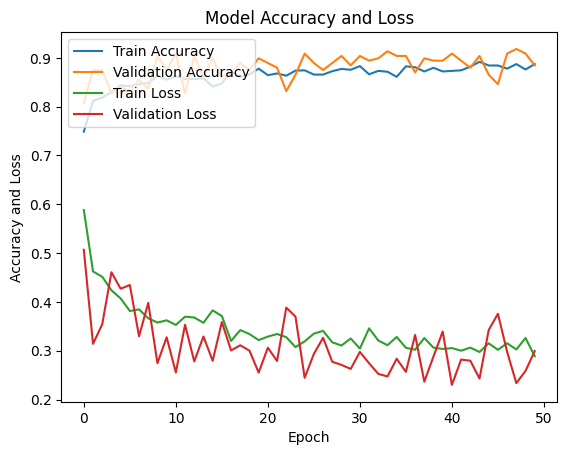

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [26]:
scores = model.evaluate(test_ds)

history.params

history.history['accuracy']

28/28 [==============================] - 30s 69ms/step - loss: 0.3206 - accuracy: 0.8616


[0.7488372325897217,
 0.8116279244422913,
 0.8186046481132507,
 0.8296511769294739,
 0.8436046242713928,
 0.8418604731559753,
 0.8459302186965942,
 0.8482558131217957,
 0.8633720874786377,
 0.8552325367927551,
 0.8627907037734985,
 0.8569767475128174,
 0.8563953638076782,
 0.8581395149230957,
 0.8412790894508362,
 0.8476744294166565,
 0.8732557892799377,
 0.8610464930534363,
 0.8662790656089783,
 0.8779069781303406,
 0.864534854888916,
 0.8680232763290405,
 0.8633720874786377,
 0.8738372325897217,
 0.8744186162948608,
 0.8656976819038391,
 0.8656976819038391,
 0.8726744055747986,
 0.8773255944252014,
 0.8755813837051392,
 0.8831395506858826,
 0.8662790656089783,
 0.8732557892799377,
 0.8715116381645203,
 0.8610464930534363,
 0.8825581669807434,
 0.8808139562606812,
 0.8720930218696594,
 0.8796511888504028,
 0.8720930218696594,
 0.8732557892799377,
 0.8744186162948608,
 0.8819767236709595,
 0.8918604850769043,
 0.8843023180961609,
 0.8843023180961609,
 0.8779069781303406,
 0.88720929622

In [27]:
history.history['val_accuracy']

[0.807692289352417,
 0.875,
 0.875,
 0.8269230723381042,
 0.8413461446762085,
 0.8317307829856873,
 0.8557692170143127,
 0.8365384340286255,
 0.9038461446762085,
 0.875,
 0.9086538553237915,
 0.8269230723381042,
 0.9038461446762085,
 0.8605769276618958,
 0.8990384340286255,
 0.8605769276618958,
 0.870192289352417,
 0.8894230723381042,
 0.875,
 0.8990384340286255,
 0.8894230723381042,
 0.879807710647583,
 0.8317307829856873,
 0.8653846383094788,
 0.9086538553237915,
 0.8894230723381042,
 0.875,
 0.8894230723381042,
 0.9038461446762085,
 0.8846153616905212,
 0.9038461446762085,
 0.8942307829856873,
 0.8990384340286255,
 0.9134615659713745,
 0.9038461446762085,
 0.9038461446762085,
 0.870192289352417,
 0.8990384340286255,
 0.8942307829856873,
 0.8942307829856873,
 0.9086538553237915,
 0.8942307829856873,
 0.879807710647583,
 0.9038461446762085,
 0.8653846383094788,
 0.8461538553237915,
 0.9086538553237915,
 0.9182692170143127,
 0.9086538553237915,
 0.8846153616905212]

In [28]:
history.history['loss']

[0.5882184505462646,
 0.462455153465271,
 0.4515783488750458,
 0.42379048466682434,
 0.4072224199771881,
 0.3814210295677185,
 0.3847939074039459,
 0.36646583676338196,
 0.3577735126018524,
 0.3623700439929962,
 0.3529277741909027,
 0.36985599994659424,
 0.36811119318008423,
 0.3573046624660492,
 0.38277122378349304,
 0.371166467666626,
 0.32007649540901184,
 0.34233054518699646,
 0.33418533205986023,
 0.3218351900577545,
 0.3290320336818695,
 0.334290474653244,
 0.3279130756855011,
 0.3073793053627014,
 0.3193042576313019,
 0.3350679576396942,
 0.3408174514770508,
 0.3173072040081024,
 0.31072285771369934,
 0.3251343369483948,
 0.30450794100761414,
 0.3459511697292328,
 0.32090073823928833,
 0.3114487826824188,
 0.32826554775238037,
 0.30613094568252563,
 0.30210110545158386,
 0.32611411809921265,
 0.3063436448574066,
 0.30368706583976746,
 0.3054688572883606,
 0.3001742660999298,
 0.30640530586242676,
 0.2975284159183502,
 0.31534674763679504,
 0.3019391894340515,
 0.3153651654720306

In [29]:
history.history['val_loss']

[0.5067660808563232,
 0.3141586482524872,
 0.3541300594806671,
 0.4608321487903595,
 0.42711591720581055,
 0.43464183807373047,
 0.3297293484210968,
 0.39807283878326416,
 0.27466291189193726,
 0.32761943340301514,
 0.2555197775363922,
 0.3533160984516144,
 0.2782162129878998,
 0.3292698860168457,
 0.2794225513935089,
 0.3587034344673157,
 0.3006461262702942,
 0.3112075924873352,
 0.30023762583732605,
 0.25526756048202515,
 0.30623918771743774,
 0.27905309200286865,
 0.3883815109729767,
 0.36995047330856323,
 0.24465836584568024,
 0.29352277517318726,
 0.326644629240036,
 0.27744048833847046,
 0.2710435688495636,
 0.2627963423728943,
 0.29761525988578796,
 0.2744188606739044,
 0.2526859939098358,
 0.2473137378692627,
 0.2836163341999054,
 0.25682517886161804,
 0.3324394226074219,
 0.23664133250713348,
 0.288455069065094,
 0.33938154578208923,
 0.23003806173801422,
 0.28195223212242126,
 0.27963578701019287,
 0.24307510256767273,
 0.34257543087005615,
 0.3757743835449219,
 0.29784825444

In [31]:
print("Accuracy: ", scores[1])
print("Loss: ", scores[0])

Accuracy:  0.8616071343421936
Loss:  0.32064083218574524


In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

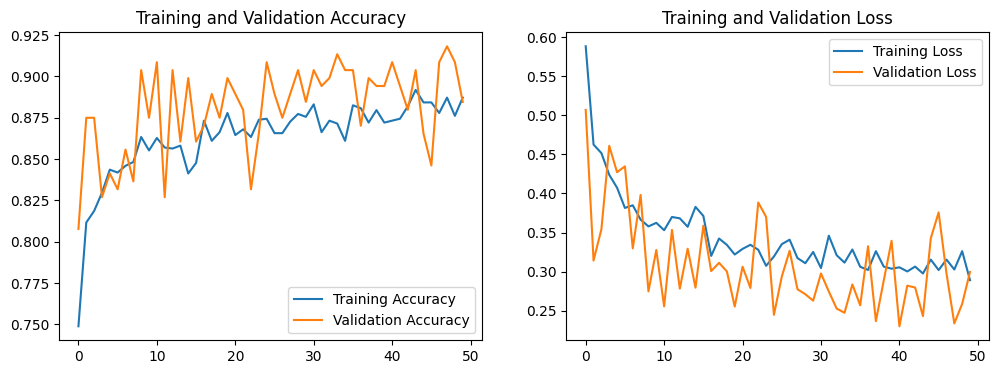

In [33]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image actual label: Potato___Early_blight
1/1 [==============================] - 2s 2s/step
[9.0176517e-01 9.8155372e-02 7.9426420e-05]
Max Value: 0
Predicted Label: Potato___Early_blight


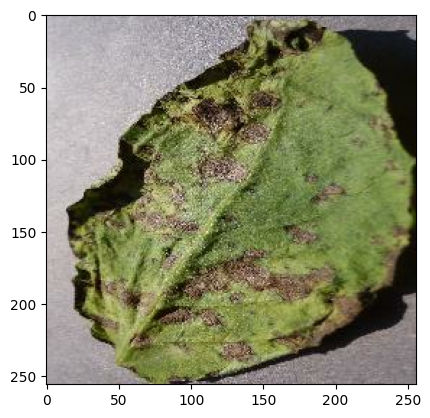

In [34]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(batch_prediction[0])
    print("Max Value:", np.argmax(batch_prediction[0]))
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 37ms/step


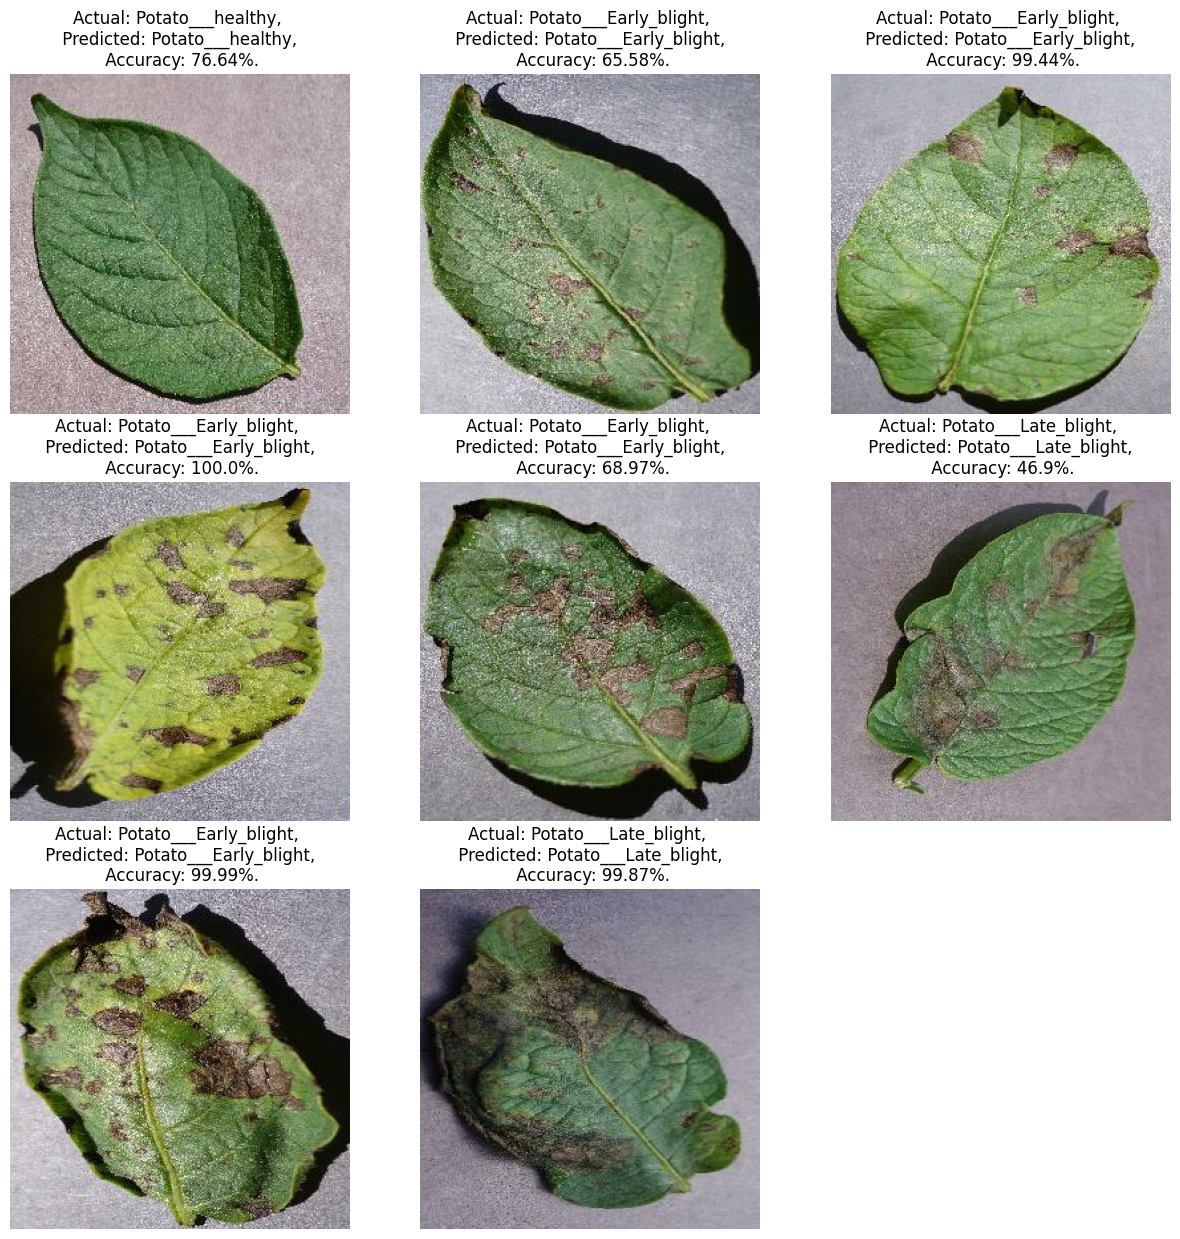

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Accuracy: {confidence}%.")  # Setting the title with actual class, predicted class, and confidence
        plt.axis("off")

In [37]:
print("Accuracy: ", scores[1] * 100)

Accuracy:  86.16071343421936


In [38]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

f1 = f1_score(y_true, y_pred, average='weighted') * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100

print("F1 Score: ", f1)
print("Precision Score: ", precision)
print("Recall Score: ", recall)

28/28 [==============================] - 3s 70ms/step
F1 Score:  42.869745652672044
Precision Score:  45.07261711502783
Recall Score:  41.964285714285715


28/28 [==============================] - 2s 68ms/step


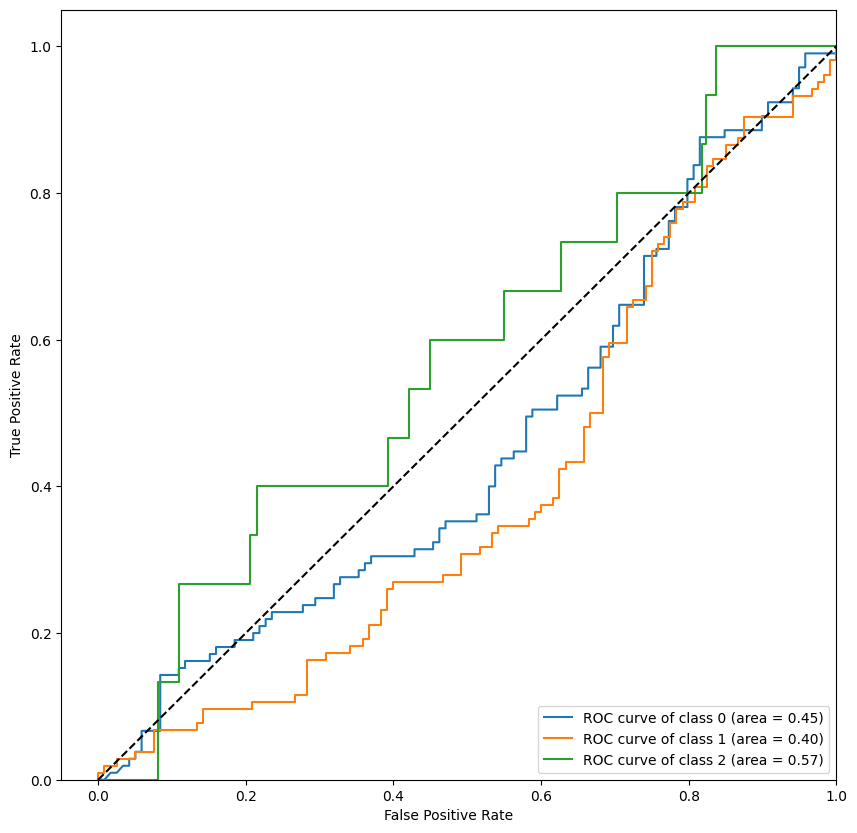

In [42]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test = label_binarize(y_true, classes=[0, 1, 2])
y_pred = model.predict(test_ds)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

28/28 [==============================] - 2s 60ms/step


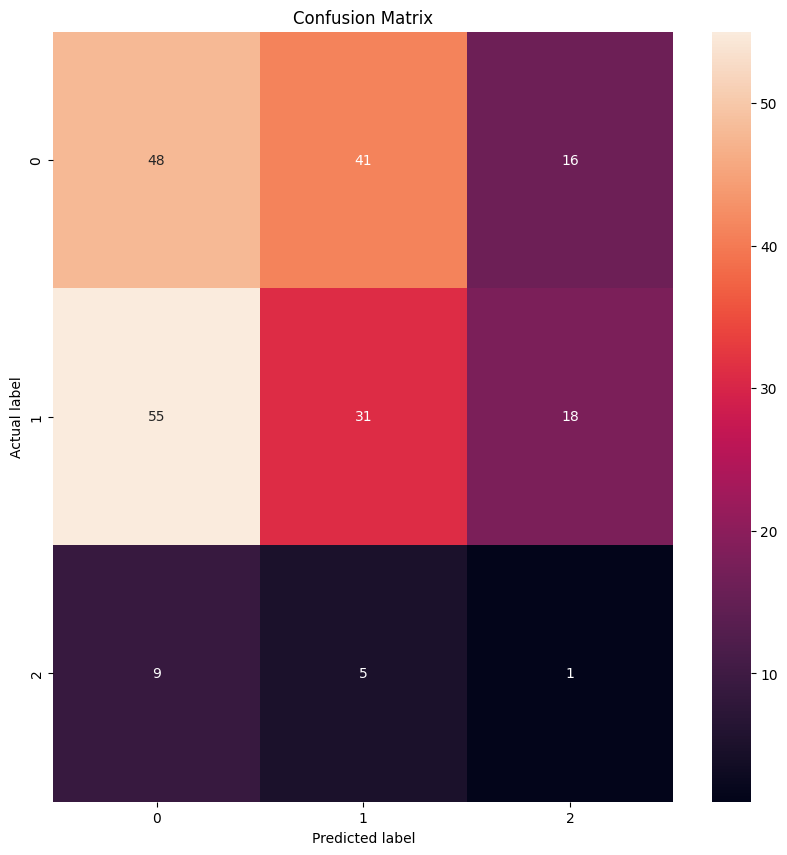

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [44]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()